<a href="https://colab.research.google.com/github/thefil9/AIProject/blob/master/Projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tytuł projektu

Dane pobrałem stąd - https://www.kaggle.com/orgesleka/used-cars-database . Są to ogłoszenia o sprzedaży samochodów z niemieckiego serwisu Ebay, zebrane w roku 2016. Na ich podstawie postaram się wyestymować cenę samochodu w zależności od jego parametrów, takich jak moc oraz licznik kilometrów,


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#autos = pd.read_csv('autos.csv', encoding='cp1252')
autos = pd.read_csv('/content/drive/My Drive/Colab Notebooks/autos.csv', encoding='cp1252')

In [3]:
autos.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Jak widać, mamy sporo kolumn, z czego nie wszystkie nas interesują, część ma też puste wartości.
Zajmijmy się wstępną obróbką danych. Najpierw zdecydujemy, jakie kolumny mogą zawierać wartościowe informacje. Kolumna name nie jest interesująca - jest to po prostu tytuł ogłoszenia. Wszystkie potrzebne informacje o autach są zawarte w innych kolumnach. Kolumna seller zawiera informacje o tym, czy sprzedawcą jest osoba prywatna, czy dealer, też jest nieistotna. Usuniemy też kolumny z datą stworzenia ogłoszenia, liczbą zdjęć, kodem pocztowym, ostatnim momentem, kiedy ogłoszenie było widoczne, miesiącem rejestracji (zostawimy rok).

In [0]:
autos = autos.drop(columns = ['dateCrawled', 'name', 'seller', 'monthOfRegistration', 'dateCreated', 'nrOfPictures', 'postalCode', 'lastSeen'])

Kolumna offerType zawiera tylko dwie wartości, z czego druga występuje bardzo rzadko. Nie wniesie żadnych informacji, więc ją usuniemy.

In [0]:
autos['offerType'].value_counts()
autos = autos.drop(columns = ['offerType'])

Załóżmy, że powypadkowe samochody nas nie iteresują. W takim razie, usuńmy wszystkie auta, które mają jakieś nienaprawione uszkodzenia.

In [0]:
autos = autos[autos['notRepairedDamage'] != 'ja']

Odfiltrujmy wartości, które na pewno nie są poprawne, np. samochody zarejestrowane w 1200 roku.

In [0]:
autos = autos[autos['yearOfRegistration'].between(1950, 2016)]
autos = autos[autos['price'].between(200, 75000)]
autos = autos[autos['powerPS'].between(30, 800)]
autos = autos[autos['kilometer'].between(1000, 400000)]

Teraz zobaczmy, czy mamy jakieś brakujące dane.

In [8]:
autos.isnull().sum()

price                     0
abtest                    0
vehicleType            9084
yearOfRegistration        0
gearbox                4622
powerPS                   0
model                  9744
kilometer                 0
fuelType              12894
brand                     0
notRepairedDamage     41985
dtype: int64

Jak widać, 5 kolumn ma brakujące dane. Możemy albo usunąć te wiersze, albo uzupełnić je innymi danymi. Ewentualnie usunąć całą kolumnę, co zrobię z kolumną notRepairedDamage ( już i tak uzyskaliśmy potrzebne z niej informacje). 

In [0]:
autos = autos.drop(columns = ['notRepairedDamage'])

W przypadku skrzyni biegów, możemy uzupełnić wartości skojarzone z marką auta ( to pole nie zawiera żadnych pustych wartości). To samo zrobimy z typem paliwa.

In [0]:
def fill_values (column_in, column_out, fill_null):
    val_dict = { 'brand_name' : ('gear_type', 1)}

    for (brand_name, gear_type), gear_count in autos.groupby(column_in)[column_out].value_counts().items():
        if brand_name in val_dict :
            if gear_count > val_dict[brand_name][1] :
                val_dict[brand_name] = (gear_type, gear_count)
        else:
            val_dict[brand_name] = (gear_type, gear_count)

    for brand_name in val_dict:
        if fill_null:
            autos.loc[(autos[column_in] == brand_name) & (autos[column_out].isnull()), column_out] = val_dict[brand_name][0] 
        else:
            autos.loc[(autos[column_in] == brand_name) & (autos[column_out] == 0), column_out] = val_dict[brand_name][0] 

fill_values('brand', 'gearbox', True)

fill_values('brand', 'fuelType', True)

Następnie usuniemy wszystkie modele, które nie istnieją, a potem uzupełnimy wartości kolumny vehicleType skojarzone z nazwą modelu.

In [0]:
autos = autos[autos['model'].notnull()]

In [0]:
fill_values('model', 'vehicleType', True)

Jak widać, nasze dane nie zawierają żadnych pustych pól. Warto też zobaczyć, w jakim stanie aktualnie jest nasz data frame.

In [13]:
print(autos.isnull().sum())
autos.head()

price                 0
abtest                0
vehicleType           0
yearOfRegistration    0
gearbox               0
powerPS               0
model                 0
kilometer             0
fuelType              0
brand                 0
dtype: int64


,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand
2,9800,test,suv,2004,automatik,163,grand,125000,diesel,jeep
3,1500,test,kleinwagen,2001,manuell,75,golf,150000,benzin,volkswagen
4,3600,test,kleinwagen,2008,manuell,69,fabia,90000,diesel,skoda
6,2200,test,cabrio,2004,manuell,109,2_reihe,150000,benzin,peugeot
8,14500,control,bus,2014,manuell,125,c_max,30000,benzin,ford


Nie przejmujemy się też tym, czy oferta była wystawion jako abtest. Dodatkowo, uzupełnijmy też wartości kolumny powerPS w miejscach, gdzie jest równa 0 - cena będzie zależna od mocy.

In [0]:
autos = autos.drop(columns = ['abtest'])

In [0]:
fill_values('model', 'powerPS', False)

In [16]:
autos.head()

,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand
2,9800,suv,2004,automatik,163,grand,125000,diesel,jeep
3,1500,kleinwagen,2001,manuell,75,golf,150000,benzin,volkswagen
4,3600,kleinwagen,2008,manuell,69,fabia,90000,diesel,skoda
6,2200,cabrio,2004,manuell,109,2_reihe,150000,benzin,peugeot
8,14500,bus,2014,manuell,125,c_max,30000,benzin,ford


Ostatnią rzeczą jaką wykonamy, jest zamienieni wszystkich kolumn z liczbami na typ numeryczny ( ponieważ niektóre są typu object) oraz zamiana kolumn z dwoma wartościami na 0 oraz 1 (czyli gearbox).

In [0]:
autos['powerPS'] = pd.to_numeric(autos['powerPS'])
autos.loc[autos['gearbox'] == 'manuell', 'gearbox'] = 0
autos.loc[autos['gearbox'] == 'automatik', 'gearbox'] = 1
autos['gearbox'] = pd.to_numeric(autos['gearbox'])

Teraz możemy sobie zwizualizować różne zależności. Zobaczmy najpierw, czy są jakieś koleracje między danymi.

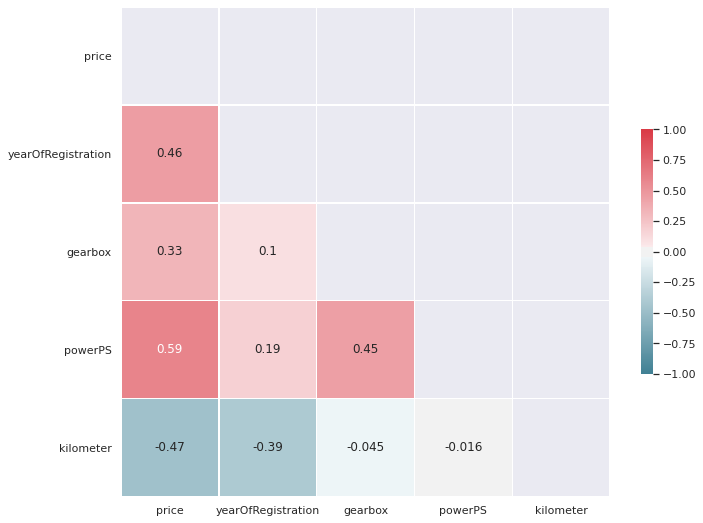

,price,yearOfRegistration,gearbox,powerPS,kilometer
price,1.000000,0.457560,0.329966,0.594244,-0.466404
yearOfRegistration,0.457560,1.000000,0.102811,0.186749,-0.392466
gearbox,0.329966,0.102811,1.000000,0.453097,-0.045247
powerPS,0.594244,0.186749,0.453097,1.000000,-0.015508
kilometer,-0.466404,-0.392466,-0.045247,-0.015508,1.000000


In [18]:
sns.set(style="darkgrid")

corr = autos.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1,
            square=True, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True)
plt.show()
corr

Jak widać, jakieś są, szczególnie, po oczyszczeniu danych ( przed były bliskie zeru). Największa koleracja (pozytywna) występuje pomiędzy ceną, a mocą auta, a największa (negatywna) między ceną, a przebiegiem.

In [19]:
autos.describe()

,price,yearOfRegistration,gearbox,powerPS,kilometer
count,270425.000000,270425.000000,270425.000000,270425.000000,270425.000000
mean,6605.044419,2003.570931,0.230696,127.871121,124360.894888
std,7609.682312,6.516198,0.421279,61.161495,39620.099580
min,200.000000,1950.000000,0.000000,30.000000,5000.000000
25%,1690.000000,2000.000000,0.000000,82.000000,100000.000000
50%,3950.000000,2004.000000,0.000000,116.000000,150000.000000
75%,8699.000000,2008.000000,0.000000,151.000000,150000.000000
max,75000.000000,2016.000000,1.000000,776.000000,150000.000000


Teraz, podzielimy dane na zestaw treningowy i testowy.

In [0]:
temp, temp2 = train_test_split(autos, test_size=0.98)
temp = temp.drop(columns = ['vehicleType','gearbox', 'fuelType', 'brand', 'model'])
autos_train, autos_test = train_test_split(temp, test_size=0.5)

In [21]:
# Put your inputs into a single list
autos_train['single_input_vector'] = autos_train[['yearOfRegistration','powerPS', 'kilometer']].apply(tuple, axis=1).apply(list)
# Double-encapsulate list so that you can sum it in the next step and keep time steps as separate elements
autos_train['single_input_vector'] = autos_train.single_input_vector.apply(lambda x: [list(x)])
# Use .cumsum() to include previous row vectors in the current row list of vectors
autos_train['cumulative_input_vectors'] = autos_train.single_input_vector.cumsum()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [22]:
# If your output is multi-dimensional, you need to capture those dimensions in one object
# If your output is a single dimension, this step may be unnecessary
autos_train['output_vector'] = autos_train[['price']].apply(tuple, axis=1).apply(list)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
# Extract your training data
X_train_init = np.asarray(autos_train[['yearOfRegistration','powerPS', 'kilometer']])
# Use hstack to and reshape to make the inputs a 3d vector
X_train = np.hstack(X_train_init).reshape(len(autos_train),1, 3)
y_train = np.hstack(np.asarray(autos_train.output_vector)).reshape(len(autos_train),1)

In [0]:
# Get your input dimensions
# Input length is the length for one input sequence (i.e. the number of rows for your sample)
# Input dim is the number of dimensions in one input vector (i.e. number of input columns)
input_length = X_train.shape[1]
input_dim = X_train.shape[2]
# Output dimensions is the shape of a single output vector
# In this case it's just 1, but it could be more
output_dim = len(y_train[0])

In [25]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense

# Build the model
model = Sequential()

# I arbitrarily picked the output dimensions as 4
model.add(LSTM(4, input_dim = input_dim, input_length = input_length))
# The max output value is > 1 so relu is used as final activation.
model.add(Dense(output_dim, activation='relu'))

model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(4, input_shape=(1, 3))`
  


In [26]:
# Set batch_size to 7 to show that it doesn't have to be a factor or multiple of your sample size
history = model.fit(X_train, y_train,
              batch_size=7, nb_epoch=3,
              verbose = 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Epoch 1/3
2704/2704 [==============================] - 1s 344us/step - loss: 60109812.3769 - accuracy: 0.0000e+00
Epoch 2/3
2704/2704 [==============================] - 1s 236us/step - loss: 57991334.2800 - accuracy: 0.0000e+00
Epoch 3/3
2704/2704 [==============================] - 1s 244us/step - loss: 57985548.0516 - accuracy: 0.0000e+00


In [27]:
# Put your inputs into a single list
autos_test['single_input_vector'] = autos_test[['yearOfRegistration','powerPS', 'kilometer']].apply(tuple, axis=1).apply(list)
# Double-encapsulate list so that you can sum it in the next step and keep time steps as separate elements
autos_test['single_input_vector'] = autos_test.single_input_vector.apply(lambda x: [list(x)])
# Use .cumsum() to include previous row vectors in the current row list of vectors
autos_test['cumulative_input_vectors'] = autos_test.single_input_vector.cumsum()
# Extract your training data
X_train_init1 = np.asarray(autos_test[['yearOfRegistration','powerPS', 'kilometer']])
# Use hstack to and reshape to make the inputs a 3d vector
X_test = np.hstack(X_train_init1).reshape(len(autos_train),1, 3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [29]:
print(X_test)
print(model.predict(X_test))

[[[  2001     60 150000]]

 [[  2002     75 125000]]

 [[  2012    170 150000]]

 ...

 [[  2009     60  90000]]

 [[  2011    170 150000]]

 [[  2011    182  50000]]]
[[6880.002]
 [6880.002]
 [6880.002]
 ...
 [6880.002]
 [6880.002]
 [6880.002]]
